# Data Generation
## Goals
* The main goal of this notebook is to generate training data for mnist object detection project
* We are going to break this task into following sub-tasks
    1. Extend `mnist` dataset with augmented data and bounding boxes
    1. Map the `n` digits to larger 100x100 images which will be used for training
* Both these tasks are further broken down into smaller tasks for easier experimentation. 
* The output of this notebook will be a bunch of reusable functions or scripts that we can use generate different training dataset for different phase of the project

## Import Libraries

In [1]:
## import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import PIL.Image

2025-07-21 09:28:55.124686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753115335.234946  101582 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753115335.272878  101582 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753115335.458206  101582 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753115335.458250  101582 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753115335.458252  101582 computation_placer.cc:177] computation placer alr

In [2]:
## validate tensorflow 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Constants

In [3]:
data_dir = Path("..","data")
models_dir = Path("..","models")

## Read Data

In [4]:
data = pd.read_csv(Path(data_dir,"raw","raw_mnist_data.csv"))
data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


## Bounding Box Generatibon

In [160]:
## helper function to plot the mnist data instances
def plot_numbers(image_df, num_of_columns = 5):
    ## lets render each image to do a quick visual inspection
    num_instances = image_df.shape[0]
    num_of_rows = int(num_instances / num_of_columns) + (1 if int(num_instances % num_of_columns) > 0 else 0)
    fig,axs = plt.subplots(num_of_rows,num_of_columns,figsize=(10,3))    
    axs = axs.ravel()
    for idx in range(0,num_instances,1):
        if(type(image_df) == np.ndarray):
            image_data = image_df[idx].reshape(28, 28)
        else:
            image_data = image_df.iloc[idx].values.reshape(28, 28)  # MNIST images are 28x28 pixels
        # Render the image using Matplotlib
        axs[idx].imshow(image_data)  # Use 'gray' colormap to render grayscale
        
        
    plt.axis("off") # Remove axes for better visualization    
    plt.show()

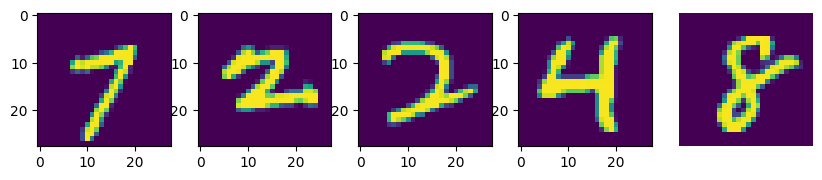

In [161]:
plot_numbers(data.sample(5).drop(columns=["class"]))

In [7]:
## lets use a small sample to test our function as we implement it
test_pixels = data.sample(2)

In [8]:
## helper function to calculate bounding box for each instance and return it. 
def map_bounding_box(mnist_intance):
    padding = 1
    ## save the current class for later
    curr_class = mnist_intance["class"]
    
    ## extract pixel information
    pixels = mnist_intance.drop(labels=["class"])
    ## reshape the pixels 
    pixels = pixels.values.reshape(28,28)
    
    ## calculate active rows & columns
    active_rows = np.sum(pixels,axis=1)
    active_columns = np.sum(pixels, axis=0)
    
    ## calculate x_min and x_max coordinate
    x_min = np.nonzero(active_columns)[0][0]
    x_max = np.nonzero(active_columns)[0][-1]
    y_min = np.nonzero(active_rows)[0][0]
    y_max = np.nonzero(active_rows)[0][-1]

    ## add padding to pixels
    x_min = x_min - (padding if (x_min != 0) else 0)
    x_max = x_max + (padding if (x_max != 27) else 0)
    y_min = y_min - (padding if (y_min != 0) else 0)
    y_max = y_max + (padding if (y_max != 27) else 0)
    
    ## calcualte x_center and y_center
    x_center = round((x_min + x_max) / 2)
    y_center = round((y_min + y_max) / 2)
    
    ## calculate width and height
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    
    return pd.Series({
        "class": curr_class,
        "x_center": x_center,
        "y_center": y_center,
        "width": width,
        "height": height
    })

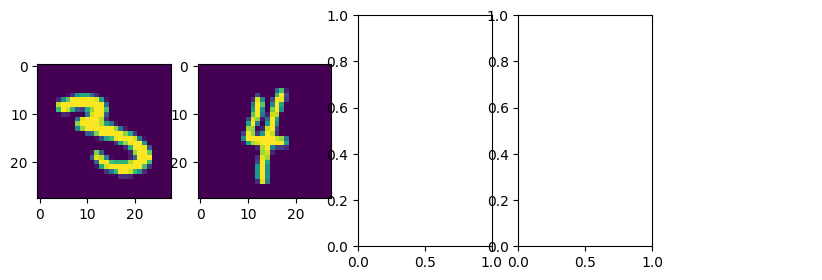

In [9]:
## plot the sample image to mental model 
plot_numbers(test_pixels.drop(columns=["class"]))
test_bounding_box = test_pixels.apply(map_bounding_box,axis=1)

In [10]:
test_bounding_box

,class,x_center,y_center,width,height
44350,3,14,14,22,20
40392,4,14,14,12,22


* So now we have the bounding box coordinates, lets quickly test them by creating the debug function that renders the bounding along with the digit

In [11]:
## since we have class in bounding box dataframe lets drop it from test pixels
test_pixels = test_pixels.drop(columns=["class"])
test_pixels


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
44350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40392,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
test_bounding_box

,class,x_center,y_center,width,height
44350,3,14,14,22,20
40392,4,14,14,12,22


## Bounding Box Visualization

In [13]:
## right now we don't know how would we uses this function, for now assumption is we'll pass in 2 dataframes
## we'll revisit the function signature as we proceed with the project
from matplotlib import patches

def visualize_bounding_box(pixel_data, target_data,num_of_columns = 5):
    num_of_columns = num_of_columns if num_of_columns <= 5 else 5
    num_instances = pixel_data.shape[0]
    num_of_rows = int(num_instances / num_of_columns) + (1 if int(num_instances % num_of_columns) > 0 else 0)

    fig,axs = plt.subplots(num_of_rows,num_of_columns,figsize=(10,3))    
    axs = axs.ravel()

    for idx in range(0,num_instances,1):

        original = tf.constant(pixel_data.iloc[idx].values.reshape(28,28,1))
        converted = tf.image.grayscale_to_rgb(original)
        
        x_center = target_data.iloc[idx]["x_center"]
        y_center = target_data.iloc[idx]["y_center"]
        width = target_data.iloc[idx]["width"]
        height = target_data.iloc[idx]["height"]
        
        x = round(x_center - (width) / 2)
        y = round(y_center - (height) / 2)

        rect = patches.Rectangle((x,y),width=width,height=height, linewidth=1, edgecolor='r', facecolor='none')
        image_data = converted.numpy().astype("uint8")
        axs[idx].imshow(image_data)
        axs[idx].add_patch(rect)
        
        axs[idx].set_title(target_data.iloc[idx]["class"])
        axs[idx].axis("off")
    plt.show()

I0000 00:00:1753115343.630367  101582 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6055 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:2d:00.0, compute capability: 7.5


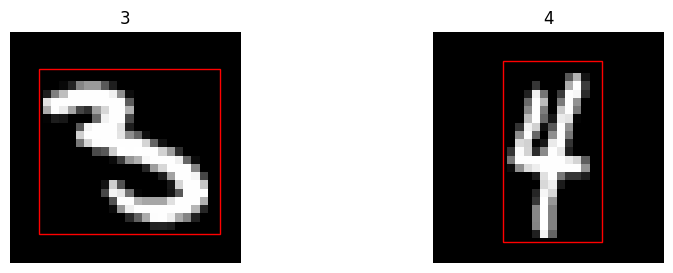

In [14]:
visualize_bounding_box(test_pixels,test_bounding_box, num_of_columns=2)

## Training Data Generation
* In this section we are going to define a simple `map` function that will map a 28x28x1 image to a 100x100x1 image.
* This function will do the following for each 28x28x1 image,
    * Randomly select `(n-1)` additional digits from global mnist dataset. Here `n` defines number of digits to overlay on 100x100x1 image. 
    * Apply `RandomAugmentation` (`RandomZoom`, `RandomTranslation`, `RandomRotation`) to these `n` images
    * Use the bounding box function to define bounding boxes for augmented images.
    * Create a blank 100x100x1 canvas
    * One at a time paste the image on this 100x100x1 canvas, by selecting non overlapping (top,left) coordinates.
    * Recalculate bounding box coordinates based on the new (top,left)
    * Return 100x100x1 image along with new output. 

* Lets break down the above algorithm into modular functions
    * `sample_base_digits(num_of_digits)` - Will return random `num_of_digits` from mnist dataset
    * `augment_digits(digits)` - Will apply random augmentation, we can also extend this to accept factor values to help convert them into hyper params.
    * `calculate_tight_bbox(mnist_instance, debug=False)` - we already have a function (`map_bounding_box`) for this, we **might** need to refactor it a bit for our flow. We can add a debug param to help render the bounded box to make sure its working as expected. 
    * `create_blank_canvas(shape=(100,100,1))` - Will create a default blank canvas to 100x100x1, but can be extended to different sizes if we want to experiment a bit. 
    * `place_digit_on_canvas(image, canvas, existing_coordinates=[])` - This function will overlay the image on top of canvas. It will use `existing_coordinates` to determine the position of the image. This is where we'll implement the logic to make sure images are not overlapping. The function will return (top,left) coordinates of the newly overlaid image.  We **might** break this into multiple functions specially the overlapping logic.  This funciton assumes image shape is 28x28x1 for now. 
    * `translate_bbox_to_canvas(current_bounding_box, coordinates)` - This function converts the existing bounding box into new ones w.r.t. coordinates. Returns the whole new bounding box object. 
    * `generate_training_example()` - Master function that will call all the above functions to generate training example.

* Lets create few sample digits for testing our implementation. After that we'll run it against whole dataset

In [15]:
test_dataset = data.sample(10)
test_dataset

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
68053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
57642,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
39694,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
16838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
66655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
58206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43330,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


* Lets declare constants that we are going to use in our map data

In [215]:
# master dataset to sample digits from
ALL_MNIST_DATA = data

# number of digits to overlay on canvas
num_of_digits = 2

# max digits to define the shape of prediction output
MAX_DIGITS = 5

### Sample Base Digits

In [125]:
# helper function to sample number of digits from master dataset
def sample_base_digits(num_of_digits):
    ## read random number of digits
    sample = ALL_MNIST_DATA.sample(num_of_digits)
    
    ## split the digits into pixels and class values
    ## reshape the data to expected values
    sample_pixels = sample.drop(columns=["class"]).to_numpy().reshape(-1,28,28,1)
    sample_values = sample["class"].values.reshape(-1,1)
    return sample_pixels,sample_values

### Augment Digits

In [166]:
def plot_before_after(before_image,after_image):
    ## lets render each image to do a quick visual inspection
    fig,axs = plt.subplots(1,2,figsize=(10,3))
    axs = axs.ravel()
    axs[0].imshow(before_image)
    axs[1].imshow(after_image)        
        
    plt.axis("off") # Remove axes for better visualization    
    plt.show()

In [ ]:
# helper function to apply random augmentation to digits
def augment_digits(digits, debug=False):
    # step 1: convert numpy digits to tensors
    tensor_digits = tf.convert_to_tensor(digits)

    # step 2: apply random augmentation
    augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomTranslation(
            height_factor=0.2, width_factor=0.2, fill_value=0.0, fill_mode="constant", seed=42),

        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2, fill_value=0.0, fill_mode="constant", seed=42),

        tf.keras.layers.RandomRotation(
            factor=0.1, fill_value=0.0, fill_mode="constant", seed=42),
    ])
    augmented_tensor_digits = augmentation(tensor_digits)
    
    # if debug is true render before digits
    if debug == True:
        for translated_imgs in range(tensor_digits.shape[0]):
            plot_before_after(tensor_digits[translated_imgs],augmented_tensor_digits[translated_imgs])

    ## convert the tensor back to numpy to simplify use in map function
    return augmented_tensor_digits.numpy()

### Calculate Tight BBox

In [206]:
## helper function to calculate bounding box for each instance and return it. 
## we are going to refactor the POC that we created ealier to use it with numpy arrays in the map function
def calculate_bounding_box(pixels, class_value, padding = 1):    
    ## calculate active rows & columns
    active_rows = np.sum(pixels,axis=1)
    active_columns = np.sum(pixels, axis=0)
    
    ## calculate x_min and x_max coordinate
    x_min = np.nonzero(active_columns)[0][0]
    x_max = np.nonzero(active_columns)[0][-1]
    y_min = np.nonzero(active_rows)[0][0]
    y_max = np.nonzero(active_rows)[0][-1]

    ## add padding to pixels
    x_min = x_min - (padding if (x_min != 0) else 0)
    x_max = x_max + (padding if (x_max != 27) else 0)
    y_min = y_min - (padding if (y_min != 0) else 0)
    y_max = y_max + (padding if (y_max != 27) else 0)
    
    ## calcualte x_center and y_center
    x_center = round((x_min + x_max) / 2)
    y_center = round((y_min + y_max) / 2)
    
    ## calculate width and height
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    
    return [x_center,y_center,width,height,class_value]

In [207]:
from matplotlib import patches

## helper function to visualize the bounding box
def visualize_bounding_box(pixel_data, target_data,num_of_columns = 5):
    num_of_columns = num_of_columns if num_of_columns <= 5 else 5
    num_instances = pixel_data.shape[0]
    num_of_rows = int(num_instances / num_of_columns) + (1 if int(num_instances % num_of_columns) > 0 else 0)

    fig,axs = plt.subplots(num_of_rows,num_of_columns,figsize=(10,3))    
    axs = axs.ravel()

    for idx in range(0,num_instances,1):

        original = tf.constant(pixel_data[idx].reshape(28,28,1))
        converted = tf.image.grayscale_to_rgb(original)
        
        x_center = target_data[idx][0]
        y_center = target_data[idx][1]
        width = target_data[idx][2]
        height = target_data[idx][3]
        
        x = round(x_center - (width) / 2)
        y = round(y_center - (height) / 2)

        rect = patches.Rectangle((x,y),width=width,height=height, linewidth=1, edgecolor='r', facecolor='none')
        image_data = converted.numpy().astype("uint8")
        axs[idx].imshow(image_data)
        axs[idx].add_patch(rect)
        
        axs[idx].set_title(target_data[idx][4])
        axs[idx].axis("off")
    plt.show()

In [208]:
## helper function to calculate bounding box for digits.
def calculate_tight_bbox(pixels,class_values, debug=False):
    class_with_bbox = np.ndarray(shape=(pixels.shape[0],5))
    for idx in range(pixels.shape[0]):
        class_with_bbox[idx] =  calculate_bounding_box(pixels[idx],class_values[idx][0])
        
    ## if debug true render digits with bbox
    if debug == True:
        visualize_bounding_box(pixels,class_with_bbox,pixels.shape[0])
    
    return class_with_bbox

### Create Blank Canvas

In [220]:
## helper function to create  blank canvas
def create_blank_canvas(shape=(100,100,1)):
    canvas = np.zeros(shape=(100,100,1), dtype=np.float32)
    return canvas

### Create Prediction Object

In [221]:
## helper function to create empty predition structure based on MAX_DIGITS
def create_prediction_object():
    prediction = np.zeros(shape=(MAX_DIGITS,15), dtype=np.float32)
    return prediction

### Place Digit On Canvas

In [383]:
def calculate_coordinates_from_center(center_x, center_y, width, height):
    min_x = round(center_x - width/2)
    min_y = round(center_y - height/2)
    max_x = round(center_x + width/2)
    max_y = round(center_y + height/2)
    return min_x, min_y, max_x, max_y


def is_valid_coordinates(top, left, class_values, existing_coordinates):
    # # make sure the top and left are withing the canvas
    # if (top + 28 >= 100 or left + 28 >= 100):
    #     return False
    # read current class values
    [curr_center_x, curr_center_y, curr_width,
        curr_height, curr_class_value] = class_values
    # recalculate center with proposed top and left values
    curr_center_x = curr_center_x + left
    curr_center_y = curr_center_y + top
    # calculate current min,max X and Y
    curr_min_x, curr_min_y, curr_max_x, curr_max_y = calculate_coordinates_from_center(
        curr_center_x, curr_center_y, curr_width, curr_height)

    # check 1: will the new bounding box go beyond the grid?
    if ((curr_min_x + curr_width) >= 100) or ((curr_min_y + curr_height) >= 100):
        return False

    # check 2: do bounding boxes overlap
    # check the current bounding box with every existing box
    for coord_idx in range(len(existing_coordinates)):
        (existing_center_x, existing_center_y, existing_width,
         existing_height) = existing_coordinates[coord_idx]
        existing_min_x, existing_min_y, existing_max_x, existing_max_y = calculate_coordinates_from_center(
            existing_center_x, existing_center_y, existing_width, existing_height)

        if ((curr_min_x <= existing_max_x and curr_max_x >= existing_min_x) and (curr_min_y <= existing_max_y and curr_max_y >= existing_min_y)):
            return False

    return True


def select_top_left(curr_class_values, existing_coordinates):
    got_valid_coordinates = False
    # limiting the loop to run only 20 times
    retries = 0
    while ((not got_valid_coordinates) and (retries < 20)):
        print(f"Selecting top/left trial # {retries}")
        top = np.random.randint(0, high=100)
        left = np.random.randint(0, high=100)
        got_valid_coordinates = is_valid_coordinates(
            top, left, curr_class_values, existing_coordinates)
        retries += retries

    if got_valid_coordinates:
        return top, left
    return -1, -1


def recalculate_center(class_values, top, left):
    # class values are center_x, center_y
    return class_values[0] + left, class_values[1] + top

# helper function to render the canvas
# update the original plotting function to plot canvas as well.


def render_canvas(canvas, class_values):
    num_of_digits = class_values.shape[0]
    fig, axs = plt.subplots(1, 1, figsize=(10, 3))
    axs.imshow(canvas)  # Use 'gray' colormap to render grayscale
    axs.axis("off")

    for idx in range(0, num_of_digits, 1):
        x_center = class_values[idx][0]
        y_center = class_values[idx][1]
        width = class_values[idx][2]
        height = class_values[idx][3]

        x = round(x_center - (width) / 2)
        y = round(y_center - (height) / 2)

        rect = patches.Rectangle(
            (x, y), width=width, height=height, linewidth=1, edgecolor='r', facecolor='none')
        axs.add_patch(rect)

    plt.show()


def place_digit_on_canvas(canvas, pixels, class_values, debug=False):
    # list to save all the valid existing coordinates
    existing_coordinates = []

    total_digits = pixels.shape[0]
    # loop thru all the pixel values
    for idx in range(total_digits):
        [center_x, center_y, width, height, class_value] = class_values[idx]
        min_x, min_y, max_x, max_y = calculate_coordinates_from_center(
            center_x, center_y, width, height)
        
        print(f"Width {width} & {int(width)}, Height {height} & {int(height)}")
        width = int(width)
        height = int(height)


        # step 1: find the right coordinates to place the digit
        top, left = select_top_left(class_values[idx], existing_coordinates)
        if top != -1 and left != -1:
            # step 2: place the digit
            print(f"reading the bounding box from {min_y}:{min_y+height}, {min_x}:{min_x+width}")
            print(f"placing the digit at {left}=>{left+width},{top}=>{top+height}")
            print(f"Source shape {pixels[idx][min_y:max_y, min_x:max_x].shape}, x {min_x},{max_x}, y {min_y},{max_y}")
            # print(f"Source shape {pixels[idx][min_y:min_y + height, min_x:min_x + width].shape}, x {min_x},{min_y}, y {min_y},{max_y}")
            canvas[top:top+height,left:left+width] = pixels[idx][min_y:max_y, min_x:max_x]
            # step 3: recalculate the center based on top,left
            new_center_x, new_center_y = recalculate_center(
                [center_x, center_y], top, left)
            # step 4: update the class values with new center
            class_values[idx][0] = new_center_x
            class_values[idx][1] = new_center_y
            # step 5: save the existing bounding box coordinates to help select the new one
            existing_coordinates.append(
                (new_center_x, new_center_y, width, height))
        else:
            print(
                f"Error placing digit {class_value} on canvas. Couldn't fild valid coordinates")

    if debug == True:
        render_canvas(canvas=canvas, class_values=class_values)

    return canvas, class_values

### Translate BBox To Canvas

In [384]:
def translate_bbox_to_canvas(current_bbox, coordinates):
    pass

### Generate Training Example

In [385]:

def generate_training_example(x,y):
    pixels = x.reshape(-1,28,28,1)
    class_values = y.reshape(-1,1)
    ## step 1: sample additional digits
    if num_of_digits - 1 > 0:
        sample_pixels, sample_values = sample_base_digits(num_of_digits - 1)
        pixels = np.concatenate((pixels, sample_pixels))
        class_values = np.concatenate((class_values, sample_values), axis=0)


    ## step 2: augment digits
    pixels = augment_digits(pixels,debug=False) 
    
    ## step 3: calculate bounding box
    class_with_bbox = calculate_tight_bbox(pixels,class_values, debug=False)
    
    ## step 4: create blank canvas and prediction
    canvas = create_blank_canvas()
    prediction = create_prediction_object()
    
    ## step 5: place digit on canvas
    canvas, class_values = place_digit_on_canvas(canvas, pixels,class_with_bbox,debug=True)
    
    print(f"pixels.shape {pixels.shape}")
    print(f"class_with_bbox.shape {class_with_bbox.shape}")
    print(f"canvas shape : {canvas.shape}")
    print(f"prediction shape : {prediction.shape}")
    
    # canvas = tf.zeros(shape=(100,100,1), dtype=tf.float32)
    # ## prediction size 1 + 14(4 for coordinates, 10 for digits) * 5 (max number of digits)
    ## todo convert this into (MAX_OBJECTS, 1 + 4 + num_classes) shape
    # prediction = tf.zeros(shape=(1,71), dtype=tf.float32)
    return (x,y)

In [ ]:
test_X = test_dataset.drop(columns=["class"])
test_y = test_dataset["class"]

X_test_tensor = tf.convert_to_tensor(test_X, dtype=tf.float32)
X_test_tensor = tf.reshape(X_test_tensor,shape=(-1,28,28,1))
y_test_tensor = tf.convert_to_tensor(test_y, dtype=tf.float32)


raw_dataset = tf.data.Dataset.from_tensor_slices((X_test_tensor,y_test_tensor))

processed_dataset = raw_dataset.map(lambda X,y : tf.numpy_function(generate_training_example,inp=[X,y], Tout=(tf.float32,tf.float32)))
dataset = processed_dataset.enumerate()
for iter, elem in dataset.as_numpy_iterator():
    print(f"elem class : {elem[1]}")

Width 22.0 & 22, Height 28.0 & 28
Selecting top/left trial # 0
Selecting top/left trial # 0
reading the bounding box from 0:28, 5:27
placing the digit at 60=>82,59=>87
Source shape (28, 22, 1), x 5,27, y 0,28
Width 23.0 & 23, Height 25.0 & 25
Selecting top/left trial # 0
reading the bounding box from 2:27, 0:23
placing the digit at 8=>31,67=>92
Source shape (24, 22, 1), x 0,22, y 2,26


2025-07-21 18:13:41.501908: W tensorflow/core/framework/op_kernel.cc:1844] INVALID_ARGUMENT: ValueError: could not broadcast input array from shape (24,22,1) into shape (25,23,1)
Traceback (most recent call last):

  File "/home/gaurangdave/workspace/mnist_object_detection/venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/gaurangdave/workspace/mnist_object_detection/venv/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_101582/3524946782.py", line 22, in generate_training_example
    canvas, class_values = place_digit_on_canvas(canvas, pixels,class_with_bbox,debug=True)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_101582/2536937392.py", line 112, in place_digit_on_canvas
    canvas[top

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to MapDataset:619 transformation with iterator: Iterator::Root::Prefetch::Zip[1]::Map: ValueError: could not broadcast input array from shape (24,22,1) into shape (25,23,1)
Traceback (most recent call last):

  File "/home/gaurangdave/workspace/mnist_object_detection/venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/gaurangdave/workspace/mnist_object_detection/venv/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_101582/3524946782.py", line 22, in generate_training_example
    canvas, class_values = place_digit_on_canvas(canvas, pixels,class_with_bbox,debug=True)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_101582/2536937392.py", line 112, in place_digit_on_canvas
    canvas[top:top+height,left:left+width] = pixels[idx][min_y:max_y, min_x:max_x]
    ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ValueError: could not broadcast input array from shape (24,22,1) into shape (25,23,1)


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

Width 22.0 & 22, Height 26.0 & 26
Selecting top/left trial # 0
reading the bounding box from -1:25, 5:27
placing the digit at 69=>91,51=>77
Source shape (0, 22, 1), x 5,27, y -1,25


2025-07-21 18:13:41.626551: W tensorflow/core/framework/op_kernel.cc:1844] INVALID_ARGUMENT: ValueError: could not broadcast input array from shape (0,22,1) into shape (26,22,1)
Traceback (most recent call last):

  File "/home/gaurangdave/workspace/mnist_object_detection/venv/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/gaurangdave/workspace/mnist_object_detection/venv/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_101582/3524946782.py", line 22, in generate_training_example
    canvas, class_values = place_digit_on_canvas(canvas, pixels,class_with_bbox,debug=True)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_101582/2536937392.py", line 112, in place_digit_on_canvas
    canvas[top: